In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import PCA
from sklearn.decomposition import PCA

In [86]:
deepfri_output = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/Metagenomic-DeepFRI/../mDeepFRI_test/test_output_2/results.tsv"
metadata = "/nfs/cds-peta/exports/biol_micro_cds_gr_sunagawa/scratch/vbezshapkin/Metagenomic-DeepFRI/notebooks/data/248_HAD_dehalogenase_subset.csv"

In [87]:
df = pd.read_csv(deepfri_output, sep='\t')
metadata_df = pd.read_csv(metadata, sep=',')

In [88]:
mode = "mf"

vector_matrix = df.query(f"DeepFRI_mode =='{mode}'")
feature_table = pd.pivot_table(vector_matrix, index="Protein", columns="GO_term/EC_number", values="Score").fillna(0)

In [89]:
labels = labels.to_list()

In [90]:
labels = metadata_df.is_defluorinating
feature_table.index = feature_table.index.str.replace("seq_", "")
# convert to int
feature_table.index = feature_table.index.astype(int) - 1
feature_table = feature_table.sort_index()

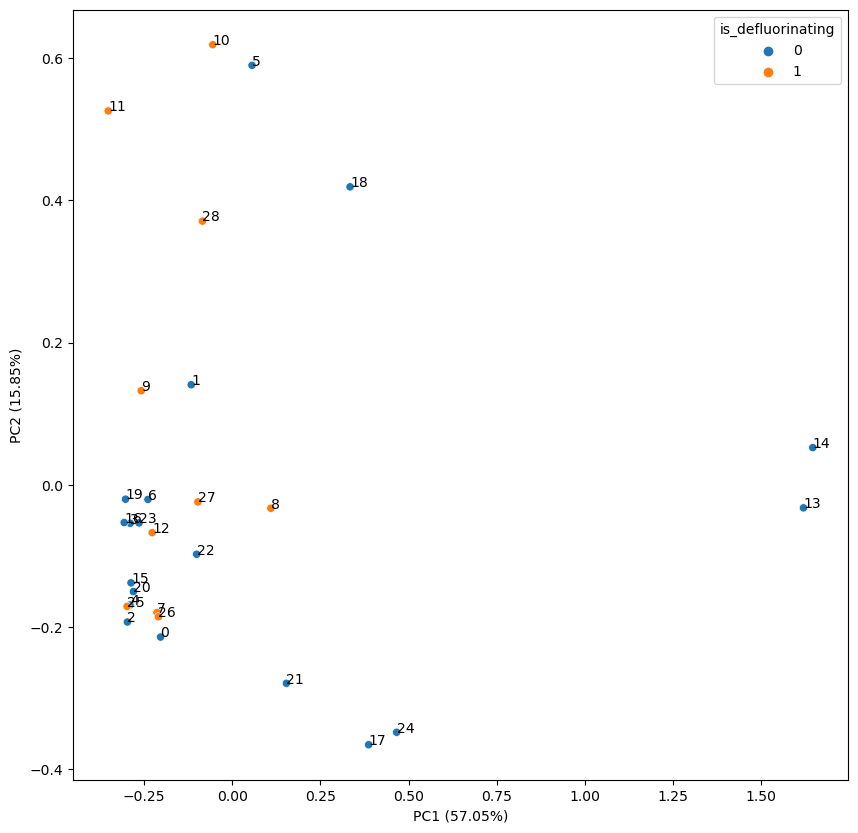

In [91]:
# make a PCA and plot a feature table
pca = PCA(n_components=2)
pca.fit(feature_table)
X_pca = pca.transform(feature_table)

# plot the PCA and color by labels
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels)

# add variance to axes
plt.xlabel(f"PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}%)")
plt.ylabel(f"PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}%)")

# add numbers over dots
for i, txt in enumerate(feature_table.index):
    plt.text(X_pca[i, 0], X_pca[i, 1], txt)

plt.show()